In [1]:
import pandas as pd
data = pd.read_csv('/Users/siddharthsachdeva/Documents/distance_data_pen1.csv')
data['captured_at'] = pd.to_datetime(data['captured_at'])
data['date'] = data['captured_at'].apply(lambda c: c.date().strftime('%Y-%m-%d'))
start, end = 7, 13
data['hour'] = data['captured_at'].apply(lambda c: c.hour)
data = data[data['hour'].between(start, end)]

In [2]:
from research.weight_estimation.keypoint_utils.optics import pixel2world 
import json

 #data['date'] = pd.to_datetime(data['captured_at']).apply(lambda d: d.date()) 
data['annotation'] = data['annotation'].apply(json.loads) 
data['camera_metadata'] = data['camera_metadata'].apply(json.loads) 
data['world_keypoints'] = data.apply(lambda row:
    pixel2world(row['annotation']['leftCrop'], row['annotation']['rightCrop'], row['camera_metadata']), axis=1)

## Distance distribution

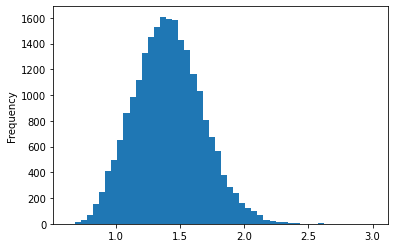

In [3]:
import numpy as np

data['distance_from_camera'] = data['world_keypoints'].apply(
    lambda kps: np.median([kp[1] for kp in kps.values()]))
data['distance_from_camera'].plot.hist(bins=50)

## Relationship between distance and weight

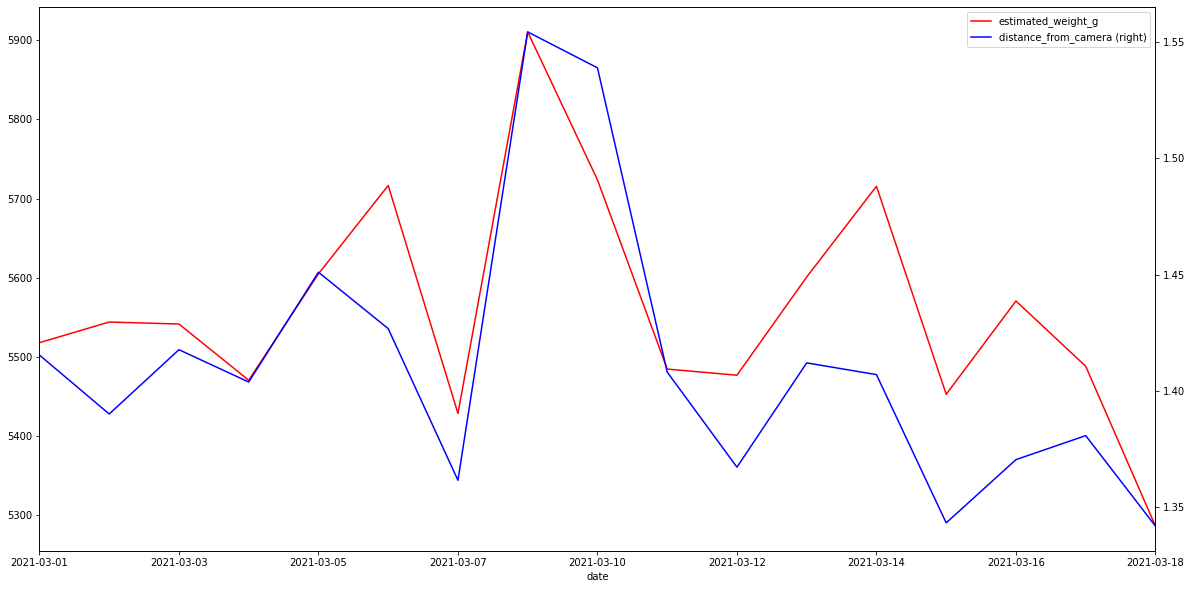

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
df = data.groupby('date')[['estimated_weight_g', 'distance_from_camera']].mean()
df.plot(y='estimated_weight_g', ax=ax, color='red')
df.plot(y='distance_from_camera', ax=ax, secondary_y=True, color='blue')

In [27]:
df.corr()

,estimated_weight_g,distance_from_camera
estimated_weight_g,1.000000,0.835061
distance_from_camera,0.835061,1.000000


## Avg weight by distance bin

In [28]:
edges = [0] + [data['distance_from_camera'].quantile(x) for x in np.arange(0.2, 1, 0.2)] + [4]


data['bin'] = pd.cut(data['distance_from_camera'], edges)
data['bin'].value_counts()

(1.469, 1.63]     4538
(1.18, 1.333]     4523
(0.0, 1.18]       4522
(1.333, 1.469]    4520
(1.63, 4.0]       4504
Name: bin, dtype: int64

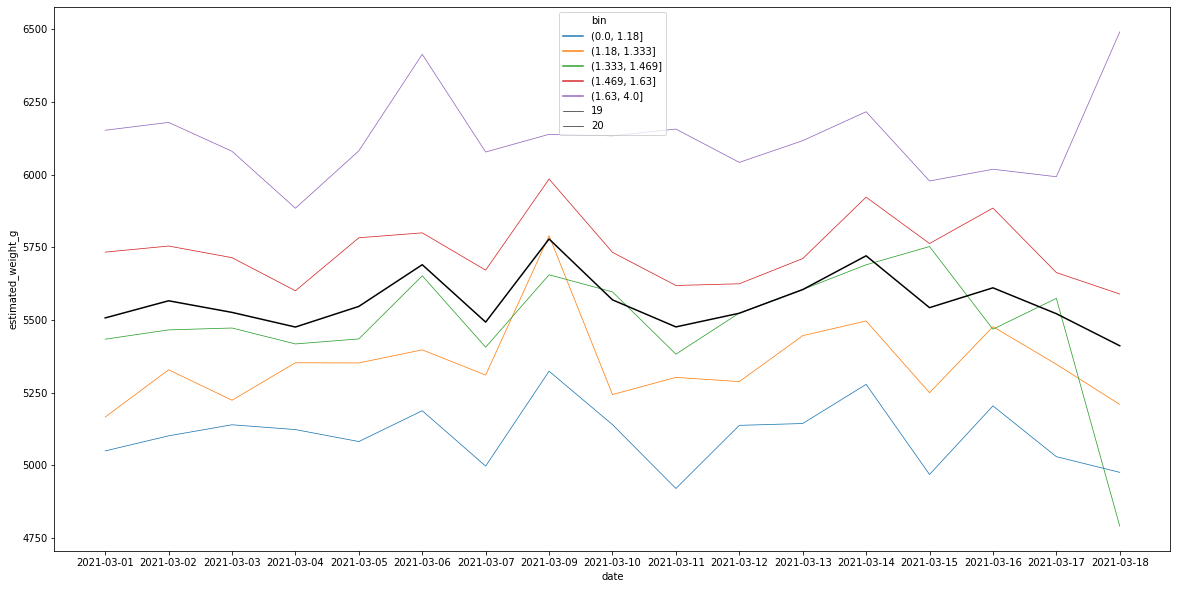

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

df = data.groupby(['date', 'bin'])['estimated_weight_g'].mean().reset_index()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df, x='date', y='estimated_weight_g', hue='bin', ax=ax, size=20)
sns.lineplot(data=df, x='date', y='estimated_weight_g', ax=ax, ci=None, color='black')
# df.plot(x='date', y=df.columns[0:2])

In [30]:
df['bin'].value_counts()

(1.63, 4.0]       17
(1.469, 1.63]     17
(1.333, 1.469]    17
(1.18, 1.333]     17
(0.0, 1.18]       17
Name: bin, dtype: int64

## Avg. weight by distance threshold

ValueError: No group keys passed!

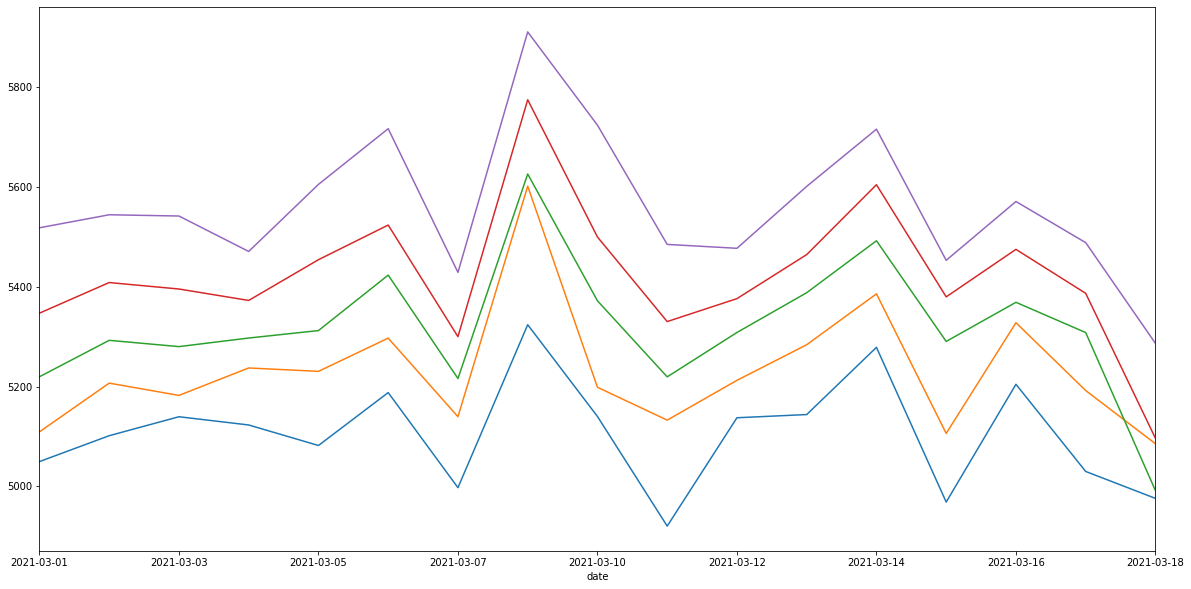

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))

cols = []
for threshold in edges[1:]:
    data[data['distance_from_camera'] < threshold].groupby('date')['estimated_weight_g'].mean().plot(ax=ax)
    
    
data.groupby(cols)

## Distribution over time

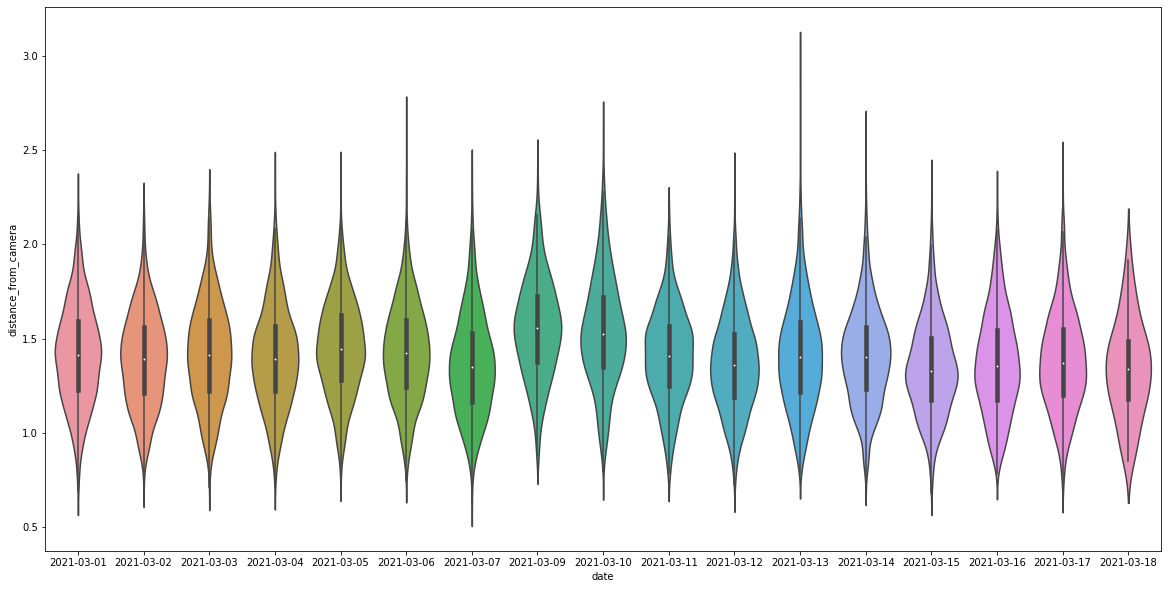

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.violinplot(data=data, x='date', y='distance_from_camera', ax=ax)

## Conclusions:

* Mean weight by distance bin and threshold doesn't make much of difference in long-term weight trend before last feeding date
* Distance Distribution does change in a significant way post reinstallation of camera, and this seems to be the major factor. However, this distribution is also expected to shift as fish get bigger. Disentangling true changes in fish weight, from optical sampling bias based on depth will be tough.